# Run the CosmoDC2 galaxies through EmpiriciSN and compare the output light curves with the training set results.

Input mode below.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.model_selection import train_test_split
from astroML.plotting import setup_text_plots
import empiriciSN
import sys
sys.path.append('/global/homes/m/mlokken/transient-host-sims/scripts/')
from empiricisn_funcs import *
import sys
import GCRCatalogs
from astropy.io import fits
import pandas as pd
import gzip
import pickle
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import table, coordinates, units as u

In [11]:
# functions
LSST_FILTERS = 'griz'

def abs_to_apparent(M, z):
    from astropy.cosmology import Planck15 as P15
    d = (P15.luminosity_distance(z).to(u.pc)).value
    m = M + 5 * np.log10(d) - 5
    return (m)

def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIax', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y

def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            
            #make mag
            sn['mag_%s' % filt] = np.array(-2.5*np.log10(np.abs(sn[filt]['fluxcal'])))+27.5
            
            sn['snr_%s' % filt] = (sn[filt]['fluxcalerr'] / np.abs(sn[filt]['fluxcal']))

        
            sn['magerr_%s' % filt] = np.array(1.086 * sn['snr_%s' % filt])
            sn['magerr_%s' % filt][sn['magerr_%s' % filt] > 0.5] = 0.5
            #  find candence
            
            sn['delta_t_%s' % filt] = [j-i for i, j in zip(sn['mjd_%s' % filt][:-1], sn['mjd_%s' % filt][1:])]
            sn['median_delta_t_%s' % filt] = np.array(np.median(sn['delta_t_%s' % filt]))
            
            sn['magobs_%s' % filt] = np.array(np.median(sn['delta_t_%s' % filt]))
            
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

Import the training data from SDSS and SNLS.

In [3]:
include_errs = False

In [4]:
flist = (['../data_files/sdss_master.csv','../data_files/snls_master.csv'])
X, Xerr, R_params = get_demo_data(flist)
#     X = [x0, x1, c, z, logr, ug, ur, ui, uz, gr, gi, gz, ri, rz, iz, SB_u, SB_g, SB_r, SB_i, SB_z]
#     R_params = [profile, umag, umag_err, urad, urad_err, gmag,
#                             gmag_err, grad, grad_err, rmag, rmag_err, rrad,
#                             rrad_err, imag, imag_err, irad, irad_err, zmag,
#                             zmag_err, zrad, zrad_err]
#     Xerr = [x0_err**2, x1_err**2, c_err**2,
#                                      z_err**2, logr_err**2, ug_err**2,
#                                      ur_err**2, ui_err**2, uz_err**2,
#                                      gr_err**2, gi_err**2, gz_err**2,
#                                      ri_err**2, rz_err**2, iz_err**2,
#                                      SB_u_err**2, SB_g_err**2,
#                                      SB_r_err**2, SB_i_err**2,
#                                      SB_z_err**2]).T


# Import the SNANA outputs for SN Ia

In [41]:
snhost, y = read_data('/global/homes/m/mlokken/transient-host-sims/data_files/MLAG_IDEAL_zALL_MODEL90_SNIa-SALT2.pkl.gz')
snhost.reset_index(drop=True)

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


In [6]:
for item in snhost.columns:
    print(item)

u
mjd_g
fluxcal_g
fluxcalerr_g
mag_g
snr_g
magerr_g
delta_t_g
median_delta_t_g
magobs_g
mjd_r
fluxcal_r
fluxcalerr_r
mag_r
snr_r
magerr_r
delta_t_r
median_delta_t_r
magobs_r
mjd_i
fluxcal_i
fluxcalerr_i
mag_i
snr_i
magerr_i
delta_t_i
median_delta_t_i
magobs_i
mjd_z
fluxcal_z
fluxcalerr_z
mag_z
snr_z
magerr_z
delta_t_z
median_delta_t_z
magobs_z
snid
z
host_specz
host_photoz
pkmjd
libid
pkmag_u
pkmag_g
pkmag_r
pkmag_i
pkmag_z
SIM_MODEL_NAME
SIM_MODEL_INDEX
SIM_TYPE_INDEX
SIM_TYPE_NAME
SIM_TEMPLATE_INDEX
SIM_LIBID
SIM_NGEN_LIBID
SIM_NOBS_UNDEFINED
SIM_SEARCHEFF_MASK
SIM_REDSHIFT_HELIO
SIM_REDSHIFT_CMB
SIM_REDSHIFT_HOST
SIM_REDSHIFT_FLAG
SIM_VPEC
SIM_HOSTLIB_GALID
SIM_HOSTLIB(galaxy_id)
SIM_HOSTLIB(GHOST_objID)
SIM_HOSTLIB(mag_true_u_lsst)
SIM_HOSTLIB(mag_true_g_lsst)
SIM_HOSTLIB(mag_true_r_lsst)
SIM_HOSTLIB(mag_true_i_lsst)
SIM_HOSTLIB(mag_true_z_lsst)
SIM_HOSTLIB(mag_true_Y_lsst)
SIM_HOSTLIB(TOTAL_ELLIPTICITY)
SIM_HOSTLIB(radius)
SIM_HOSTLIB(NBR_LIST)
SIM_HOSTLIB(LOGMASS_TRUE)
SIM_HOSTLI

Retrieve the relevant properties from SNANA file and CosmoDC2

In [143]:
galid = snhost['SIM_HOSTLIB(galaxy_id)']
unq_galid, unq_idx = np.unique(galid, return_index = True)
sim_z = snhost['z'].iloc[unq_idx]
sim_hlr = snhost['SIM_HOSTLIB(radius)'].iloc[unq_idx]
x0_snana = snhost['SIM_SALT2x0'].iloc[unq_idx]
x1_snana = snhost['SIM_SALT2x1'].iloc[unq_idx]
c_snana = snhost['SIM_SALT2c'].iloc[unq_idx]

In [104]:
cosmodc2hlr= dc2.get_quantities('size_true')


In [55]:
dc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
filters=[(lambda x: np.in1d(x, unq_galid), 'galaxy_id')]
cdc2_data = dc2.get_quantities(['Mag_true_u_lsst_z0', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0', 'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 'morphology/totalSersicIndex'], filters=filters)

In [238]:
cMag_u = cdc2_data['Mag_true_u_lsst_z0']
cMag_g = cdc2_data['Mag_true_g_lsst_z0']
cMag_r = cdc2_data['Mag_true_r_lsst_z0']
cMag_i = cdc2_data['Mag_true_i_lsst_z0']
cMag_z = cdc2_data['Mag_true_z_lsst_z0']

sim_magu = abs_to_apparent(cMag_u, sim_z)
sim_magg = abs_to_apparent(cMag_g, sim_z)
sim_magr = abs_to_apparent(cMag_r, sim_z)
sim_magi = abs_to_apparent(cMag_i, sim_z)
sim_magz = abs_to_apparent(cMag_z, sim_z)
sim_n    = cdc2_data['morphology/totalSersicIndex']
# needs to be 1 or 4
sim_n[sim_n < 2.5] = 1
sim_n[sim_n > 2.5] = 4

zeros   = np.zeros(len(sim_magu))

    
# append all of the relevant parameters to make simX like X. The logR and Surface Brightness values will be added on later
# First 3 are left out because those are calculated later
simX   = np.vstack([sim_z, sim_magu-sim_magg, sim_magu-sim_magr, sim_magu-sim_magi, sim_magu-sim_magz, sim_magg-sim_magr,\
        sim_magg-sim_magi, sim_magg-sim_magz, sim_magr-sim_magi, sim_magr-sim_magz, sim_magi-sim_magz]).T
no_err = np.zeros(simX.shape[0])
no_err[:] = 10**-5
zeros  = np.zeros(simX.shape[0])
simRparams = np.vstack([sim_n, sim_magu, no_err, sim_hlr, no_err, sim_magg, no_err, sim_hlr, no_err, sim_magr, no_err,
                    sim_hlr, no_err, sim_magi, no_err, sim_hlr, no_err, sim_magz, no_err, sim_hlr, no_err]).T
simXerr = np.zeros(simX.shape + simX.shape[-1:])
diag = np.arange(simX.shape[-1])

simXerr[:,  diag,  diag] = np.vstack([zeros**2, zeros**2,
                                 zeros**2, zeros**2, zeros**2,
                                 zeros**2, zeros**2, zeros**2,
                                 zeros**2, zeros**2, zeros**2]).T



The following is copied directly from the EmpiriciSN demo notebook.

## Component Test

We could fit our supernova/host dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.

In [239]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
flist = (['../data_files/sdss_master.csv','../data_files/snls_master.csv'])
X, Xerr, R_params = get_demo_data(flist)

#     X = [x0, x1, c, z, logr, ug, ur, ui, uz, gr, gi, gz, ri, rz, iz, SB_u, SB_g, SB_r, SB_i, SB_z]
#     R_params = [profile, umag, umag_err, urad, urad_err, gmag,
#                             gmag_err, grad, grad_err, rmag, rmag_err, rrad,
#                             rrad_err, imag, imag_err, irad, irad_err, zmag,
#                             zmag_err, zrad, zrad_err]
#     Xerr = [x0_err**2, x1_err**2, c_err**2,
#                                      z_err**2, logr_err**2, ug_err**2,
#                                      ur_err**2, ui_err**2, uz_err**2,
#                                      gr_err**2, gi_err**2, gz_err**2,
#                                      ri_err**2, rz_err**2, iz_err**2,
#                                      SB_u_err**2, SB_g_err**2,
#                                      SB_r_err**2, SB_i_err**2,
#                                      SB_z_err**2]).T


# Loop over component numbers, fitting XDGMM model and computing the BIC. 
# This takes 30 minutes or so. Uncomment this line to run the test, but 
# to save time you can just accept the values below.

# bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

bics = np.array([-7586.49881994, -19276.8161054, -24393.2132252, -24178.7063611, 
                 -23154.5882926, -23740.5529757, -22697.0279733, -20953.6879974])
lowest_bic = -24393.2132252
optimal_n_comp = 3

> According to the EmpiriciSN paper, testing indicated that a 6 component model provides a superior fit to the data. Thus, for the rest of the demo we will use 6 components in the model.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our SN dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict supernovae and compare with our predicted sample.

In [240]:
# Split dataset 65/35
X_train, X_test, Xerr_train, Xerr_test, R_param_train, R_param_test = \
    train_test_split(X, Xerr, R_params, test_size=0.35, random_state=42)
# Read the model:
empiricist.read_model('../data_files/demo_model.fit')

## Predicting a Likely Supernova

For the rest of this demo we will show how to use a model that has been fit to predict realistic supernovae from known host quantities. 

Since some of the quantities used to fit the model require knowledge of the supernova location (e.g., local surface brightness), this is a multi-step process. 

* First, we will use a subset of the host properties to select a likely location. 

* Then we will compute the local surface brightness, and use the full set of host parameters to condition the XDGMM model and sample a realistic supernova.

The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.

### Selecting the SN location within the host galaxy

<!-- One desired function of this tool is to provide a realistic location for a supernova within a host, along with realistic supernova properties. However, our overall model is trained with both overall host properties, like color and redshift, and the local surface brightness at the location of the supernova. In order for our tool to allow the user to fit a supernova based on host photometry and a surface brightness profile, we have provided a way to select a location for the supernova based on a subset of host properties so that local surface brightness can be calculated, and then the full set of host properties can be used to condition the model to provide supernova properties. -->

The `get_logR` function:

* takes as input an array of host properties, an array of corresponding indices in the dataset that is being fit, and the index of the $\log{R/R_e}$ quantity in the dataset;

* conditions the model based on the input host properties; 

* and returns a value for $\log{R/R_e}$ that is sampled from the conditioned model. 

We built the function to accept any number of host parameters and any indices from the input data for its conditioning set in order to make it as general as possible. However, for this demo we will use the redshift of the host and its 10 $ugriz$ colors, but with a different set of data the separation could be fit for any properties by simply passing the correct indeces into `get_logR`. 

> The only restriction on the data being passed in is that the first 3 indices of the dataset are reserved for the 3 `SALT2` supernova properties; apart from that, any properties (at any index in the dataset) can be used.

In [241]:
# Get actual separations from dataset, for comparison:
train_logR = X_train[:,4]
test_logR  = X_test[:,4]

# Predict a radial separation for each host:
np.random.seed(0)
cond_indices = np.array([3,5,6,7,8,9,10,11,12,13,14])
# These are z, ug, ur, ui, uz, gr, gi, gz, ri, rz, iz


def logR(simX, simXerr):
    n = 0 #counter
    sim_logR = np.array([])
    for x in range(len(simX)):
        # cond_indices is where I put the indices of their data which correspond to the parameters I want to use.
        # get_logR takes the indices you want to train on, the index of R in the set used to train, and the parameters to feed in that match the training ones
        r = empiricist.get_logR(cond_indices,4,simX[x], simXerr[x])
        sim_logR = np.append(sim_logR,r)
        if n % 1000 == 0:
            print("%.0f percent complete" %(n/len(simX)*100))
        n += 1
    return sim_logR


sim_logR = logR(simX, simXerr)


0 percent complete
42 percent complete
84 percent complete


In [242]:
# Check the test logR's
test_sample_logR = np.array([])
for x in X_test:    
    r2 = empiricist.get_logR(cond_indices,4,x[cond_indices])
    test_sample_logR = np.append(test_sample_logR, r2)

<Figure size 432x288 with 0 Axes>

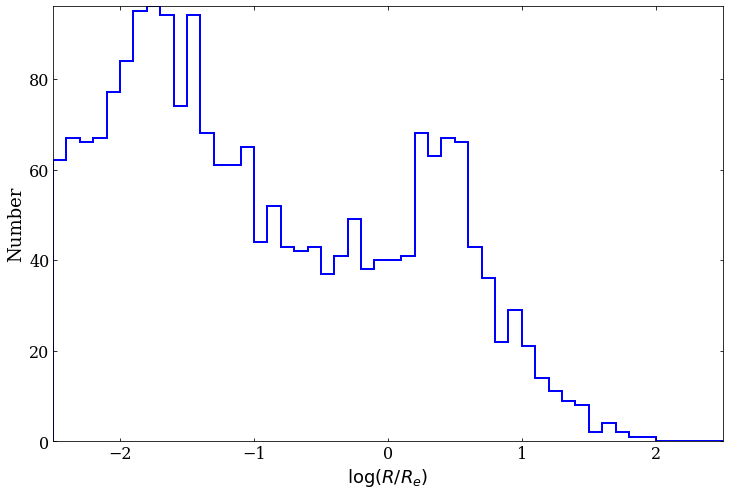

In [243]:
def plot_separation(sim_R):
    plt.clf()
    setup_text_plots(fontsize = 16, usetex = False)
    fig = plt.figure(figsize = (12,8))
    plt.hist(sim_R, 50, histtype = 'step', color = 'blue',lw = 2,
             label = 'Predictions (Buzzard Hosts)', range = (-2.5,2.5))
    plt.xlabel("$\log(R/R_e)$", fontsize=18)
    plt.ylabel("Number", fontsize=18)
    plt.xlim(-2.5, 2.5)
    plt.show()
    

plot_separation(sim_logR)


Now we have a set of test separations in units of log(R/Re) and a set of separations sampled from the model. These should have the same distribution when plotted.

<Figure size 432x288 with 0 Axes>

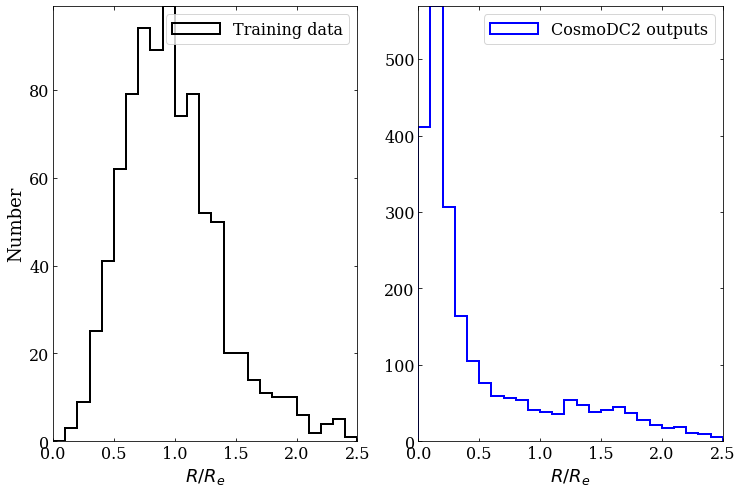

In [244]:
def plot_separation_sidebyside(train_R, sample_R, log=True):
    plt.clf()
    setup_text_plots(fontsize = 16, usetex = False)
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,8))
    if log==False:
        train_R  = np.exp(train_R)
        sample_R = np.exp(sample_R)

    axes[0].hist(train_R, 50, histtype = 'step', color = 'black', lw = 2,
             label = 'Training data', range = (-2.5,2.5))
    axes[1].hist(sample_R, 50, histtype = 'step', color = 'blue',lw = 2,
             label = 'CosmoDC2 outputs', range = (-2.5,2.5))

    axes[0].legend(loc="best")
    axes[1].legend(loc="best")
    if log == True:
        axes[0].set_xlabel("$\log(R/R_e)$", fontsize=18)
        axes[1].set_xlabel("$\log(R/R_e)$", fontsize=18)
        axes[0].set_xlim([-3,3])
        axes[1].set_xlim([-3,3])
    elif log == False:
        axes[0].set_xlabel(r"$R/R_e$", fontsize=18)
        axes[1].set_xlabel(r"$R/R_e$", fontsize=18)
        axes[0].set_xlim([0,2.5])
        axes[1].set_xlim([0,2.5])
    axes[0].set_ylabel("Number", fontsize=18)
    plt.show()
    

plot_separation_sidebyside(train_logR, sim_logR, log=False)

<Figure size 432x288 with 0 Axes>

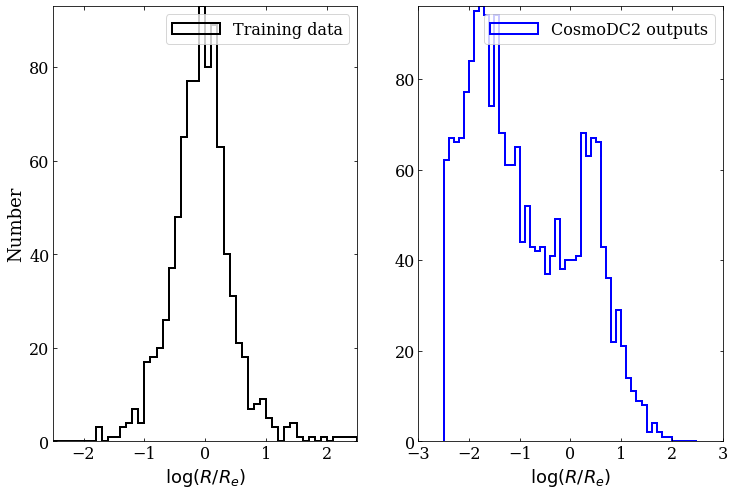

In [245]:
def plot_separation_sidebyside(train_R, sample_R):
    plt.clf()
    setup_text_plots(fontsize = 16, usetex = False)
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (12,8))

    axes[0].hist(train_R, 50, histtype = 'step', color = 'black', lw = 2,
             label = 'Training data', range = (-2.5,2.5))
    axes[1].hist(sample_R, 50, histtype = 'step', color = 'blue',lw = 2,
             label = 'CosmoDC2 outputs', range = (-2.5,2.5))

    axes[0].legend(loc="best")
    axes[1].legend(loc="best")
    axes[0].set_xlabel("$\log(R/R_e)$", fontsize=18)
    axes[1].set_xlabel("$\log(R/R_e)$", fontsize=18)
    axes[0].set_ylabel("Number", fontsize=18)
    plt.xlim(-3, 3)
    plt.show()
    

plot_separation_sidebyside(train_logR, sim_logR)


### Calculating Local Surface Brightness

Now that we have locations for each test SN, we can calculate the local surface brightness based on the appropriate surface brightness profile (Exponential or de Vaucouleurs) and the host magnitude and effective radius in each filter.

In order to save space here, the actual surface brightness calculation is done in the `get_local_SB` function in the accompanying `demo_funcs` file.

In [246]:
def local_SB(simRparams, sim_logR):
    local_SB = []
    local_SB_err = []
    n = 0 # counter
    
    for i in range(len(simRparams)):
        # SB_params: array_like, shape = (21,)
                #Array of parameters needed for the SB fit. First entry 
                #should be a sersic index of 1 or 4 (ML: I have these for VAGC catalog), indicating whether to
                #use an exponential or de Vaucouleurs profile. Following this
                #should be sets of 
                #(magnitude, mag_unc (uncertainty), effective radius (ML: same as half-light), rad_unc) data for
                #each of the 5 ugriz filters (ML: check if these are the same for SDSS and LSST), giving a total array length of
                #21. These data are assumed to be known by the user.

        SB, SB_err  = empiricist.get_local_SB(simRparams[i],sim_logR[i])
        local_SB.append(SB)
        local_SB_err.append(SB_err)
        if n % 1000 == 0:
            print("%.0f percent complete" %(n/len(sim_logR)*100))
        n += 1
    return np.asarray(local_SB), np.asarray(local_SB_err)

sim_local_SB, sim_local_SB_err = local_SB(simRparams, sim_logR)

0 percent complete
42 percent complete
84 percent complete


### Predicting Supernova Parameters

Now that we have the local surface brightnesses and separations, we can generate supernova parameters using our full range of host parameters (redshift, separation, colors, and local surface brightnesses). 

First, let's plot the distributions of supernova parameters in our test sample.

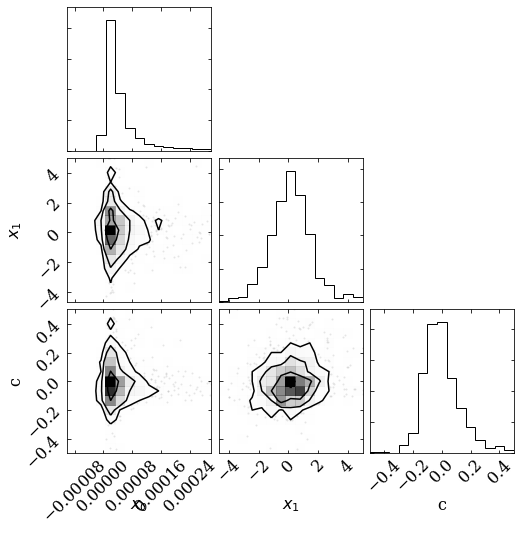

In [247]:
figure = corner.corner(X_train[:,0:3], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)], bins=15, use_math_text=True)


Next we will use our host properties to predict a supernova for each host, then plot those with the test sample. Ideally, these distributions should be the same as those from the test sample.

In [248]:
def SN(sim_logR, simX, simXerr, local_SB, local_SB_err):

    # Set up an array to contain the new supernova properties:
    n_Hosts = len(sim_logR)
    print(n_Hosts)
    sim_SNe = np.zeros([n_Hosts,3])

    np.random.seed(10)

    # Loop over host galaxies, conditioning on each one's properties and drawing one supernova:
    for i in range(n_Hosts):

        x = np.append(simX[i][0],sim_logR[i]) # redshift, logR
        x = np.append(x,simX[i][1:11])
        x = np.append(x,local_SB[i])
        x = np.append(np.array([np.nan,np.nan,np.nan]),x)
        # x = [nan,nan,nan,z,logR,ug, ur, ui, uz, gr, gi, gz, ri, rz, iz,SB_u,SB_g,SB_r,SB_i,SB_z]
        xerr = np.array([0.0,0.0,0.0]) # input 0 for errors on 3 SN params
        xerr = np.append(xerr, simXerr[i,0,0]) # z err
        xerr = np.append(xerr, 0.0) # 0 for logR err
        for j in range(1,simXerr.shape[1]):
            xerr = np.append(xerr,simXerr[i,j,j])
        xerr = np.append(xerr,local_SB_err[i])
        # xerr = [0,0,0,zerr,0,ugerr, urerr, uierr, uzerr, grerr, gierr, gzerr, rierr, rzerr, izerr,SB_uerr,SB_gerr,SB_rerr,SB_ierr,SB_zerr]
        try:
            sim_SNe[i] = empiricist.get_SN(x, Xerr=xerr, n_SN=1)
        except:
            print("error")
        if i % 100 == 0:
            print(i)
    return sim_SNe

sim_SNe = SN(sim_logR, simX, simXerr, sim_local_SB, sim_local_SB_err)


2393
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


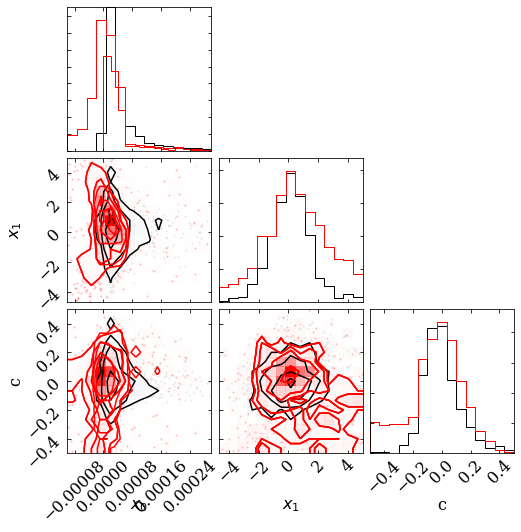

In [276]:

corner.corner(sim_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='red', range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)],
                             fig=figure, bins=15)

# figure.savefig("/global/u2/m/mlokken/lsst_sn1a_in_gals/sn-lightcurves-for-buzzard-gals-for-github/plots/cdc2_{:s}_snresults_z_4colors_1mag_n_rad_zero_errs.png".format(nn_mode))

In [250]:
# def plot_salt2_params_zbins(train_sne, sample_sne, train_z, sample_z, saveroot=None):
#     for i in range(5):
#         zmin = i * 0.2
#         zmax = i * 0.2 + 0.2
#         train_in_bin = (train_z < zmax) & (train_z > zmin)
#         sample_in_bin = (sample_z < zmax) & (sample_z > zmin)
#         plt.clf()
#         setup_text_plots(fontsize = 16, usetex = False)
#         figure = corner.corner(train_sne[train_in_bin], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)], color='black')
#         corner.corner(sample_sne[sample_in_bin], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)], fig=figure, color='blue')
#         print(len(train_sne[train_in_bin]), len(sample_sne[sample_in_bin]))
#         if saveroot != None:
#             plt.savefig(saveroot+"_zbin_%d.png"%(i+1))

# saveroot = "plots/cdc2_{:s}_sample_salt2".format(nn_mode)
# plot_salt2_params_zbins(X_train[:,0:3], onenn_SNe[:,0:3], X_train[:,3], onenn_X[:,0], saveroot=saveroot)

## Plotting vs SNANA

In [251]:
n = len(x0_snana)
salt2_snana = np.hstack((x0_snana.values.reshape((n,1)), x1_snana.values.reshape((n,1)), c_snana.values.reshape((n,1))))

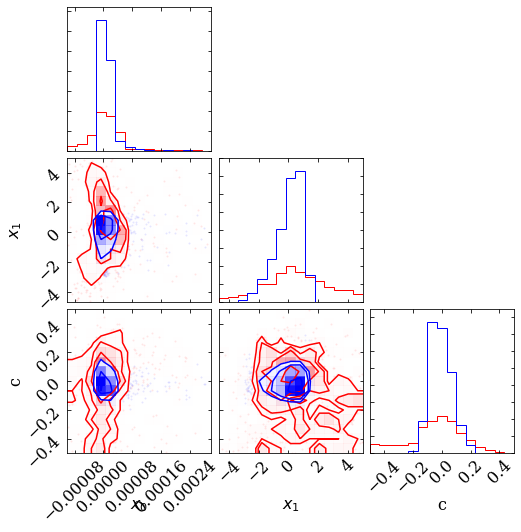

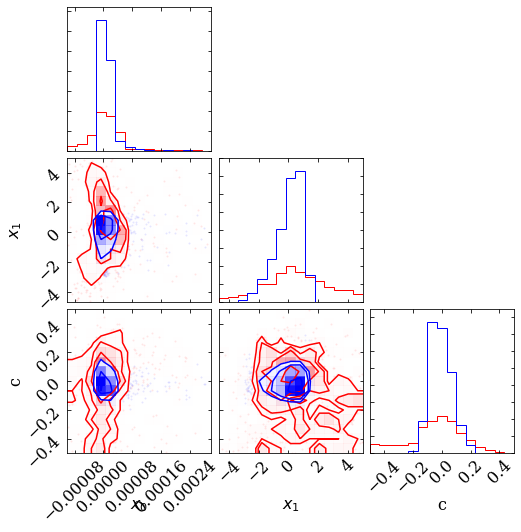

In [225]:

# fig2 = corner.corner(X_train[:,0:3], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)], bins=15, use_math_text=True)

fig2 = corner.corner(sim_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='red', range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)],
                             bins=15)

corner.corner(salt2_snana[:,0:3], labels=['$x_0$','$x_1$','c'], color='blue', range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)],
                             fig=fig2, bins=15)

# figure.savefig("/global/u2/m/mlokken/lsst_sn1a_in_gals/sn-lightcurves-for-buzzard-gals-for-github/plots/cdc2_{:s}_snresults_z_4colors_1mag_n_rad_zero_errs.png".format(nn_mode))

Text(0.5, 1.0, 'SNANA')

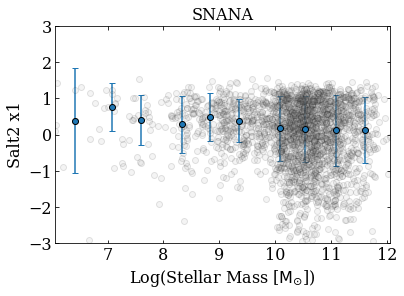

In [217]:
logmass = snhost['SIM_HOSTLIB(LOGMASS_TRUE)'].iloc[unq_idx]
mass_bins = []
x1_bins = []
sigmas = []
step = (max(logmass)- min(logmass))/10.
for i in np.arange(min(logmass), max(logmass), step):
    mass_bin = logmass[(logmass<i+step) & (logmass>i)]
    mass = np.median(mass_bin)
    x1_bin   = x1_snana[(logmass<i+step) & (logmass>i)]
    x1 = np.median(x1_bin)
    std = np.std(x1_bin)
    sigmas.append(std)
    mass_bins.append(mass)
    x1_bins.append(x1)
plt.errorbar(mass_bins, x1_bins, yerr=sigmas, fmt='o')
plt.ylim([-3,3])
plt.plot(logmass, x1_snana, 'o', color='0.6', alpha=.1)
plt.xlabel("Log(Stellar Mass [$\mathrm{M}_{\odot}$])")
plt.ylabel("Salt2 x1")
plt.title("SNANA")

Text(0.5, 1.0, 'EmpiriciSN')

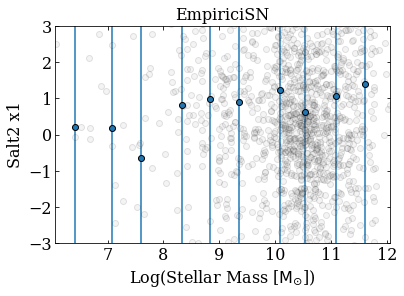

In [295]:
mass_bins = []
x1_bins = []
sigmas = []
step = (max(logmass)- min(logmass))/10.
for i in np.arange(min(logmass), max(logmass), step):
    mass_bin = logmass[(logmass<i+step) & (logmass>i)]
    mass = np.median(mass_bin)
    x1_bin   = sim_SNe[:,1][(logmass<i+step) & (logmass>i)]
    std = np.std(x1_bin)
    sigmas.append(std)
    x1 = np.median(x1_bin)
    mass_bins.append(mass)
    x1_bins.append(x1)
plt.errorbar(mass_bins, x1_bins, yerr=sigmas, fmt='o')
plt.ylim([-3,3])
plt.plot(logmass, sim_SNe[:,1], 'o', color='0.6', alpha=.1)
plt.xlabel("Log(Stellar Mass [$\mathrm{M}_{\odot}$])")
plt.ylabel("Salt2 x1")
plt.title("EmpiriciSN")


Text(0.5, 1.0, 'SNANA')

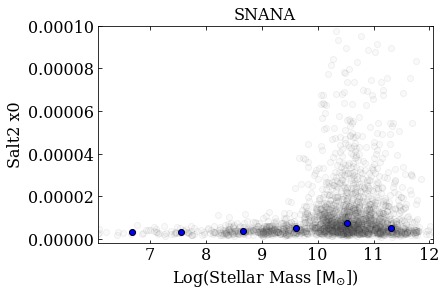

In [310]:
mass_bins = []
x0_bins = []
sigmas = []
step = (max(logmass)- min(logmass))/6.
for i in np.arange(min(logmass), max(logmass), step):
    mass_bin = logmass[(logmass<i+step) & (logmass>i)]
    mass = np.median(mass_bin)
    x0_bin   = x0_snana[(logmass<i+step) & (logmass>i)]
    x0 = np.median(x0_bin)
    std = np.std(x0_bin)
    sigmas.append(std)
    mass_bins.append(mass)
    x0_bins.append(x0)
plt.plot(logmass, x0_snana, 'o', color='0.6', alpha=.05)

plt.plot(mass_bins, x0_bins, 'bo')
plt.ylim([-.000002,.0001])
plt.xlabel("Log(Stellar Mass [$\mathrm{M}_{\odot}$])")
plt.ylabel("Salt2 x0")
plt.title("SNANA")

Text(0.5, 1.0, 'EmpiriciSN')

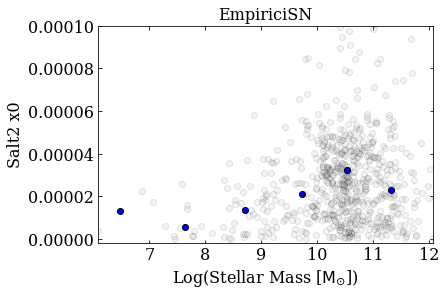

In [311]:
mass_bins = []
x0_bins = []
sigmas = []
x0_above0 = sim_SNe[:,0]>0
step = (max(logmass)- min(logmass))/6.
for i in np.arange(min(logmass), max(logmass), step):
    mass_bin = logmass[x0_above0 & ((logmass<i+step) & (logmass>i))]
    mass = np.median(mass_bin)
    x0_bin   = sim_SNe[:,0][x0_above0 & ((logmass<i+step) & (logmass>i))]
    std = np.std(x0_bin)
    sigmas.append(std)
    x0 = np.median(x0_bin)
    mass_bins.append(mass)
    x0_bins.append(x0)
plt.plot(logmass[x0_above0], sim_SNe[:,0][x0_above0], 'o', color='0.6', alpha=.1)

plt.plot(mass_bins, x0_bins, 'bo')
plt.ylim([-.000002,.0001])
plt.xlabel("Log(Stellar Mass [$\mathrm{M}_{\odot}$])")
plt.ylabel("Salt2 x0")
plt.title("EmpiriciSN")


# Testing the results

Convert x to mu

In [67]:
cosmo = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
mass = cosmo['stellar_mass'][idx.astype(int)]
idx = np.loadtxt("cdc2_gals_1nn_trainset_idx.txt")
z = cosmo['redshift']
z_i = z[idx.astype(int)]
mu_DC2 = cosmo.cosmology.distmod(z_i)

In [68]:
x0_out = onenn_SNe[:,0]
x1_out = onenn_SNe[:,1]
c_out  = onenn_SNe[:,2]

In [70]:
# Quick version from Rahul
mBstr = -2.5*np.log10(x0_out) + 10.485

# following from Betoule et al 2014, Table 10, SDSS+SNLS(stat+sys)
def M_B(stellar_mass):
    M_B1 = -19.04
    delta_M = -0.061
    if stellar_mass > 10**10:
        M_B = M_B1 + delta_M
    else:
        M_B = M_B1
    return M_B

mu_out = np.zeros(len(x0_out))
alpha  = 0.140
beta   = 3.140
for i in range(len(x0_out)):
    mu_out[i] = mBstr[i] - (M_B(mass[i])-alpha*x1_out[i]+beta*c_out[i])


/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0, 0.5, '$\\mu_{pred} - \\mu_{DC2}$')

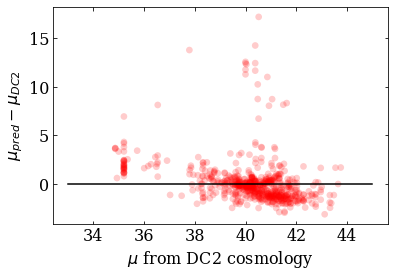

In [92]:
plt.scatter(mu_DC2.value, mu_out - mu_DC2.value, c='red', alpha=0.2, edgecolor='None', s = 45)
plt.plot([33, 45], [0,0], 'k')
plt.xlabel(r'$\mu$ from DC2 cosmology')
plt.ylabel(r'$\mu_{pred} - \mu_{DC2}$')

Text(0, 0.5, '$\\mu_{pred} - \\mu_{DC2}$')

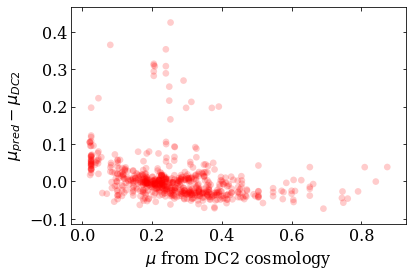

In [139]:
plt.scatter(z_i, (mu_out - mu_DC2.value)/mu_DC2.value, c='red', alpha=0.2, edgecolor='None', s = 45)

plt.xlabel(r'$\mu$ from DC2 cosmology')
plt.ylabel(r'$\mu_{pred} - \mu_{DC2}$')

Text(0, 0.5, '$\\mu_{pred} - \\mu_{DC2}$')

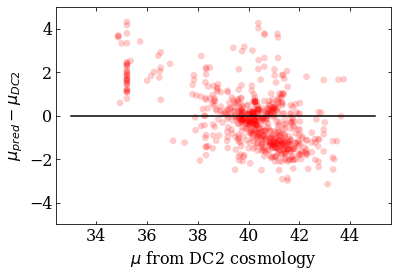

In [95]:
plt.scatter(mu_DC2.value, mu_out - mu_DC2.value, c='red', alpha=0.2, edgecolor='None', s = 45)
plt.plot([33, 45], [0,0], 'k')
plt.ylim([-5,5])
plt.xlabel(r'$\mu$ from DC2 cosmology')
plt.ylabel(r'$\mu_{pred} - \mu_{DC2}$')

(0, 1000)

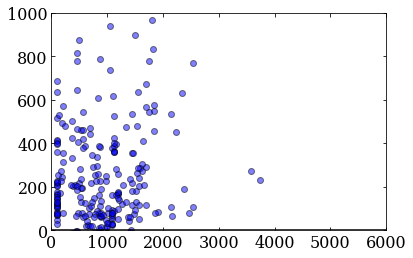

In [113]:
dist_pc_dc2 = 10**(1+mu_DC2.value/5) / 10**6
dist_pc_out = 10**(1+mu_out/5) / 10**6
plt.plot(dist_pc_dc2, (dist_pc_out-dist_pc_dc2), 'bo', alpha=.5)
plt.plot([0, 6000], [0,0], 'k')
plt.ylim([0,1000])

Null test: random DC2 galaxies

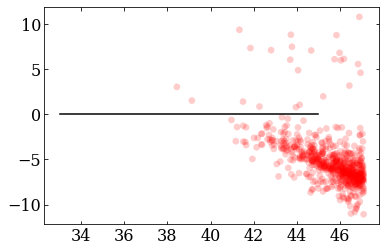

In [137]:
idx_to_choose_from = np.arange(0, len(z), 10000)
rand_idx = np.random.choice(idx_to_choose_from, size=len(idx), replace=False)
mu_rand = cosmo.cosmology.distmod(z[rand_idx])
plt.scatter(mu_rand.value, mu_out - mu_rand.value, c='red', alpha=0.2, edgecolor='None', s = 45)
plt.plot([33, 45], [0,0], 'k')

In [123]:
unique, counts = np.unique(rand_idx, return_counts=True)
for i in range(len(counts)):
    if counts[i] > 1:
        print(unique[i], counts[i])


7257 2
22325 2
22788 2
24607 2
32551 2
37790 2
47840 2


Import Pan-STARRS data and compare the simulated SN Ia to Pan-STARRS data across redshifts.

In [113]:
ps1phot  = "data_files/ps1phot_psnid.fitres"
ps1mag   = "data_files/ps1mag_full.txt"
specconf = "data_files/specconf.list"

In [114]:
ps1phot_table = pd.read_csv(ps1phot, index_col=False, delimiter =' ', names=['Stupid', 'CID', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR', 'VPEC', 'VPEC_ERR', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'ITYPE_BEST', 'SIM_ITYPE', 'Z_Ia', 'SHAPEPAR_Ia', 'COLORPAR_Ia', 'COLORLAW_Ia', 'TMAX_Ia', 'DMU_Ia', 'TOBSMIN_Ia', 'TOBSMAX_Ia', 'CHI2_Ia', 'NPT_Ia', 'FITPROB_Ia', 'PBAYES_Ia', 'LCQ_Ia', 'Ze_Ia', 'SHAPEPARe_Ia', 'COLORPARe_Ia', 'COLORLAWe_Ia', 'TMAXe_Ia', 'DMUe_Ia', 'Z_Ibc', 'NONIA_INDEX_Ibc', 'COLORPAR_Ibc', 'COLORLAW_Ibc', 'TMAX_Ibc', 'DMU_Ibc', 'TOBSMIN_Ibc', 'TOBSMAX_Ibc', 'CHI2_Ibc', 'NPT_Ibc', 'FITPROB_Ibc', 'PBAYES_Ibc', 'LCQ_Ibc', 'Z_II', 'NONIA_INDEX_II', 'COLORPAR_II', 'COLORLAW_II', 'TMAX_II', 'DMU_II', 'TOBSMIN_II', 'TOBSMAX_II', 'CHI2_II', 'NPT_II', 'FITPROB_II', 'PBAYES_II' 'LCQ_II', 'Z_PEC1A', 'NONIA_INDEX_PEC1A', 'COLORPAR_PEC1A', 'COLORLAW_PEC1A', 'TMAX_PEC1A', 'DMU_PEC1A', 'TOBSMIN_PEC1A', 'TOBSMAX_PEC1A' 'CHI2_PEC1A', 'NPT_PEC1A', 'FITPROB_PEC1A', 'PBAYES_PEC1A', 'LCQ_PEC1A'], skiprows=25) 
ps1mag_table  = pd.read_csv(ps1mag, index_col=False, delimiter=' ', names=['ID', 'gmag', 'gmagerr', 'g_zpt', 'rmag', 'rmagerr', 'r_zpt', 'imag', 'imagerr', 'i_zpt', 'zmag', 'zmagerr', 'z_zpt' 'ymag', 'ymagerr', 'y_zpt', 's_a', 's_b', 's_theta', 'n', 'r_eff', 'ellipt'], skiprows=1)
spec_table    = pd.read_csv(specconf, index_col=False, delimiter=' ', names=['name','z','class'])

Turn this data into something that can be compared with my simulated SN: the SALT2 parameters.

In [115]:
ps1phot_table = ps1phot_table.drop(ps1phot_table.index[0])


In [116]:
ps1phot_table

,Stupid,CID,IDSURVEY,TYPE,FIELD,CUTFLAG_SNANA,zCMB,zCMBERR,zHD,zHDERR,...,COLORPAR_PEC1A,COLORLAW_PEC1A,TMAX_PEC1A,DMU_PEC1A,TOBSMIN_PEC1A,TOBSMAX_PEC1ACHI2_PEC1A,NPT_PEC1A,FITPROB_PEC1A,PBAYES_PEC1A,LCQ_PEC1A
1,SN:,PS0909006,15.0,0.0,NaN,1.0,0.2840,0.001,0.2840,0.001,...,502.0,-0.95,1.7,55081.0,-1.1,-95.4,1547.3,168.2780,23.0,4.496840e-24
2,SN:,PSc000511,15.0,0.0,NaN,1.0,0.4566,0.001,0.4566,0.001,...,502.0,-1.00,1.7,56334.0,-2.0,-1157.4,420.3,5.5377,2.0,6.273370e-02
3,SN:,PSc040530,15.0,0.0,NaN,1.0,0.2654,0.001,0.2654,0.001,...,502.0,-1.00,1.7,55345.0,-1.6,-404.4,1196.3,856.4397,56.0,1.182240e-143
4,SN:,PSc052224,15.0,0.0,NaN,1.0,0.3703,0.001,0.3703,0.001,...,502.0,0.25,1.7,55233.0,-0.9,-71.4,1521.3,117.5893,65.0,7.103720e-05
5,SN:,PSc070516,15.0,0.0,NaN,1.0,0.1919,0.001,0.1919,0.001,...,502.0,-0.75,1.7,55407.0,-1.5,-334.4,1270.3,1335.6383,63.0,9.431990e-238
6,SN:,PSc080380,15.0,0.0,NaN,1.0,0.5563,0.001,0.5563,0.001,...,503.0,-0.25,1.7,55450.0,-2.0,-509.4,1198.4,153.6702,37.0,3.653660e-16
7,SN:,PSc090999,15.0,0.0,NaN,1.0,0.4745,0.001,0.4745,0.001,...,502.0,-1.00,1.7,55494.0,-2.0,-421.4,1183.3,911.7649,39.0,5.979030e-166
8,SN:,PSc120304,15.0,0.0,NaN,1.0,0.3702,0.001,0.3702,0.001,...,502.0,-0.55,1.7,55576.0,-0.7,-414.4,1178.3,77.2789,55.0,2.545550e-02
9,SN:,PSc130308,15.0,0.0,NaN,1.0,0.0818,0.001,0.0818,0.001,...,502.0,-0.25,1.7,55602.0,-1.2,-673.5,909.3,416.4880,44.0,3.875900e-62
10,SN:,PSc150507,15.0,0.0,NaN,1.0,0.0729,0.001,0.0729,0.001,...,509.0,-0.60,1.7,55683.0,0.5,-522.4,1071.3,1116.1402,36.0,6.155890e-211


In [117]:
shapepar = ps1phot_table['SHAPEPAR_Ia']
colorpar = ps1phot_table['COLORPAR_Ia']
colorlaw = ps1phot_table['COLORLAW_Ia']
z_Ia_ps1 = ps1phot_table['Z_Ia']
ps1_salt2 = np.vstack([shapepar, colorpar]).T

Color parameter is $c$ in the SALT2 paper, $x_1$ is shape parameter

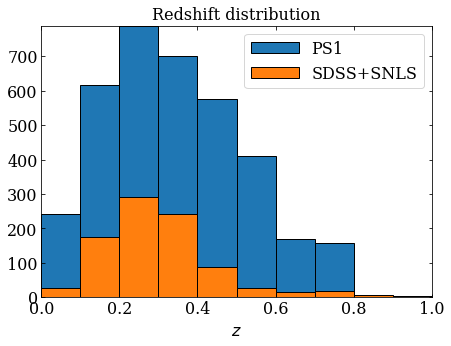

In [122]:
plt.figure(figsize=[7,5])
plt.hist(z_Ia_ps1, range=[0,1], label='PS1')
plt.hist(X_train[:,3], range=[0,1], label='SDSS+SNLS')
plt.title("Redshift distribution")
plt.xlabel("$z$")
plt.legend()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 894 but corresponding boolean dimension is 3661

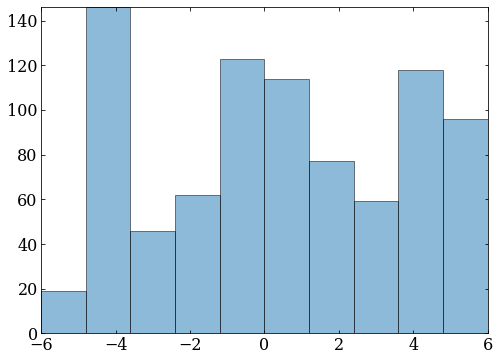

In [126]:
plt.figure(figsize=[8,6])
for i in range(3):
    zmin = i * 0.2
    zmax = i * 0.2 + 0.2
    train_in_bin = (z_Ia_ps1 < zmax) & (z_Ia_ps1 > zmin)
    sample_in_bin = (onenn_X[:,0] < zmax) & (onenn_X[:,3] > zmin)
    plt.clf()
    setup_text_plots(fontsize = 16, usetex = False)
    plt.hist(ps1_salt2[:,0][train_in_bin], range=[-6,6], label='ps1', alpha=.5)
    plt.hist(onenn_SNe[:,1][sample_in_bin], range=[-6,6], label='Buzzard',alpha=.5, linestyle='--')
    plt.ylim([0, 275])
    plt.xlabel("$x_1$")
    plt.ylabel("Number of SNIa in bin")
    plt.legend()
    plt.savefig("ps1_buzz_onenn_salt2params"+"_zbin_%d.png"%(i+1))

(array([   7.,   31.,   96.,  173.,  242.,  213.,  102.,   42.,   21.,   10.]),
 array([-4.7 , -3.73, -2.76, -1.79, -0.82,  0.15,  1.12,  2.09,  3.06,
         4.03,  5.  ]),
 <a list of 10 Patch objects>)

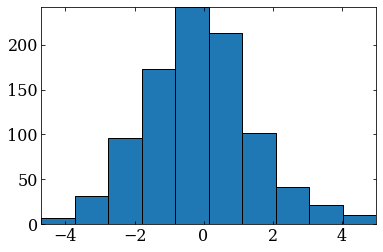

In [72]:
plt.hist(multinn_SNe[:,1], range=[-4.7,5])

(array([   4.,   24.,   80.,  165.,  236.,  241.,  110.,   43.,   24.,   10.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

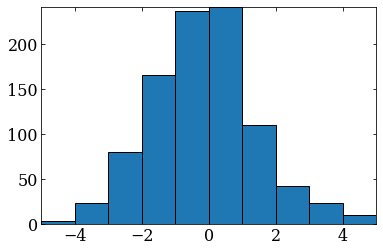

In [67]:
plt.hist(multinn_SNe[:,1], range=[-5,5])

(array([ 234.,  232.,  254.,  402.,  639.,  686.,  389.,  186.,  173.,  466.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Patch objects>)

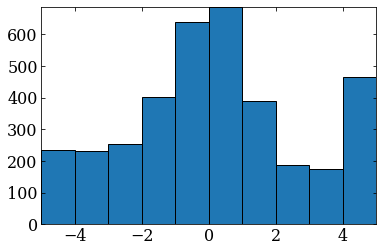

In [68]:
plt.hist(shapepar)

(array([    0.,     0.,     0.,     0.,     0.,  3661.,     0.,     0.,
            0.,     0.]),
 array([-9.5, -9.4, -9.3, -9.2, -9.1, -9. , -8.9, -8.8, -8.7, -8.6, -8.5]),
 <a list of 10 Patch objects>)

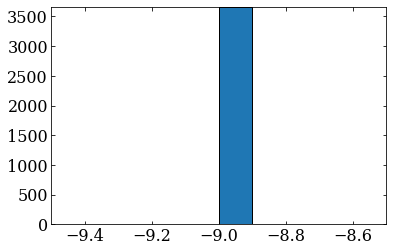

In [69]:
plt.hist(colorlaw)

(array([   1.,    1.,    0.,    1.,    0.,    3.,    2.,    1.,    5.,
           6.,    1.,    7.,    4.,    5.,    6.,    8.,   17.,    9.,
          20.,   43.,   52.,   68.,   80.,  100.,   90.,   92.,   79.,
          72.,   58.,   44.,   19.,   30.,   15.,   10.,    6.,   10.,
           5.,    5.,    4.,    2.,    2.,    1.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

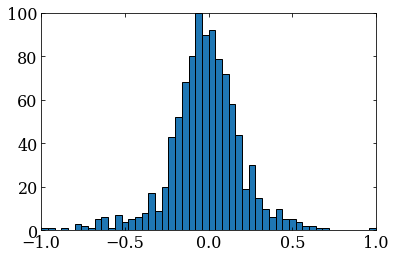

In [70]:
plt.hist(multinn_SNe[:,2], bins=50, range=[-1,1])